In [1]:
from xcube.api.readwrite import read_cube
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dask.distributed import Client, progress
%matplotlib inline
np.warnings.filterwarnings('ignore')

In [3]:
import cartopy.crs as ccrs
#import graphviz

In [4]:
client = Client()

In [5]:
client

Client Scheduler: tcp://127.0.0.1:64863 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.08 GB


In [ ]:
#ds = read_cube('https://obs.eu-de.otc.t-systems.com/dcs4cop-obs-01/OLCI-SNS-RAW-CUBE-2.zarr')

In [14]:
ds = read_cube("C:\\Users\\Norman\\EOData\\DCS4COP\OLCI-SNS-RAW-CUBE.zarr")

In [33]:
from xcube.api.extract import get_cube_values_for_points

In [51]:
times = np.array(['2016-12-04T10:23:52.691372544', '2016-12-05T14:23:52.691372544'], dtype="datetime64[ns]")

In [60]:
points = df = dict(lat=np.array([52., 52.5]), lon=np.array([2., 2.1]), time=times)

df = pd.DataFrame(points)
df

,lat,lon,time
0,52.0,2.0,2016-12-04 10:23:52.691372544
1,52.5,2.1,2016-12-05 14:23:52.691372544


In [61]:
extract = get_cube_values_for_points(ds, points, include_indexes=True)
extract

<xarray.Dataset>
Dimensions:        (bnds: 2, idx: 2)
Coordinates:
    lat_bnds       (idx, bnds) float64 dask.array<shape=(2, 2), chunksize=(2, 2)>
    lon_bnds       (idx, bnds) float64 dask.array<shape=(2, 2), chunksize=(2, 2)>
    time_bnds      (idx, bnds) datetime64[ns] dask.array<shape=(2, 2), chunksize=(1, 2)>
    lat            (idx) float64 50.0 50.5
    lon            (idx) float64 2.001 2.101
    time           (idx) datetime64[ns] 2016-12-04T10:23:52.691372544 2016-12-05T09:58:10.083663104
    lat_end        (idx) float64 dask.array<shape=(2,), chunksize=(2,)>
    lat_start      (idx) float64 dask.array<shape=(2,), chunksize=(2,)>
    lon_end        (idx) float64 dask.array<shape=(2,), chunksize=(2,)>
    lon_start      (idx) float64 dask.array<shape=(2,), chunksize=(2,)>
    time_end       (idx) datetime64[ns] dask.array<shape=(2,), chunksize=(1,)>
    time_start     (idx) datetime64[ns] dask.array<shape=(2,), chunksize=(1,)>
Dimensions without coordinates: bnds, idx
Data

In [62]:
extract.conc_chl.values, extract.conc_tsm.values

(array([nan, nan]), array([nan, nan]))

In [63]:
ds

<xarray.Dataset>
Dimensions:        (bnds: 2, lat: 1000, lon: 2000, time: 216)
Coordinates:
  * lat            (lat) float64 52.5 52.5 52.49 52.49 ... 50.01 50.01 50.0 50.0
    lat_bnds       (lat, bnds) float64 dask.array<shape=(1000, 2), chunksize=(1000, 2)>
  * lon            (lon) float64 0.00125 0.00375 0.00625 ... 4.994 4.996 4.999
    lon_bnds       (lon, bnds) float64 dask.array<shape=(2000, 2), chunksize=(2000, 2)>
  * time           (time) datetime64[ns] 2016-11-24T09:43:16.372487168 ... 2017-10-23T00:50:20.883619584
    time_bnds      (time, bnds) datetime64[ns] dask.array<shape=(216, 2), chunksize=(1, 2)>
Dimensions without coordinates: bnds
Data variables:
    c2rcc_flags    (time, lat, lon) float64 dask.array<shape=(216, 1000, 2000), chunksize=(1, 1000, 2000)>
    conc_chl       (time, lat, lon) float64 dask.array<shape=(216, 1000, 2000), chunksize=(1, 1000, 2000)>
    conc_tsm       (time, lat, lon) float64 dask.array<shape=(216, 1000, 2000), chunksize=(1, 1000, 2000)>
 

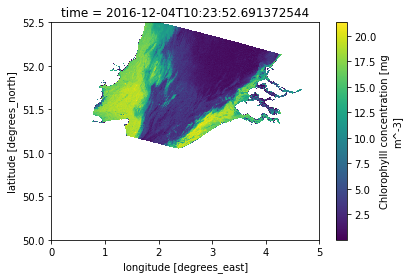

In [64]:
ds.conc_chl.isel(time=9).plot.imshow()

In [18]:
ds.conc_chl.isel(time=9)

<xarray.DataArray 'conc_chl' (lat: 1000, lon: 2000)>
dask.array<shape=(1000, 2000), dtype=float64, chunksize=(1000, 2000)>
Coordinates:
  * lat      (lat) float64 52.5 52.5 52.49 52.49 52.49 ... 50.01 50.01 50.0 50.0
  * lon      (lon) float64 0.00125 0.00375 0.00625 0.00875 ... 4.994 4.996 4.999
    time     datetime64[ns] 2016-12-04T10:23:52.691372544
Attributes:
    color_table_blue_values:    [128, 255, 255, 255, 255, 0, 0, 0, 0, 0]
    color_table_green_values:   [0, 0, 102, 204, 255, 128, 255, 95, 0, 0]
    color_table_red_values:     [0, 0, 51, 0, 0, 0, 255, 255, 215, 150]
    color_table_sample_values:  [0.0, 0.5, 1.0, 2.0, 3.0, 4.5, 13.0, 25.0, 30...
    long_name:                  Chlorophylll concentration
    sample_frequencies:         [19, 51, 53, 77, 73, 67, 65, 63, 72, 47, 69, ...
    statistics:                 [0.21163521707057953, 20.046144485473633, 8.1...
    units:                      mg m^-3
    valid_pixel_expression:     c2rcc_flags.Valid_PE

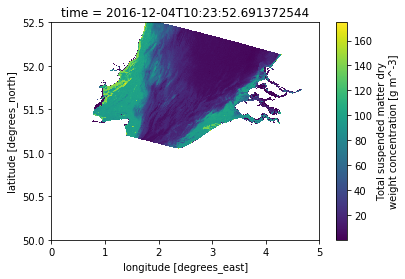

In [19]:
ds.conc_tsm.sel(time='2016-12-04T10:23:52.691372544', method='nearest').plot.imshow()

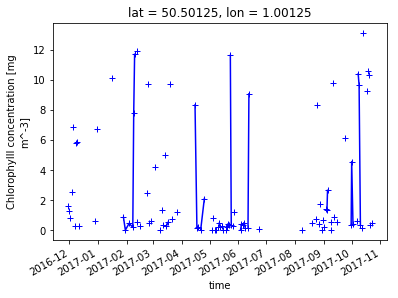

In [20]:
ds.conc_chl.sel(lon=1., lat=50.5, method='nearest').plot.line('b-+')

In [21]:
ds_resampled = ds.resample(time='14d',skipna = True, keep_attrs=True).mean()

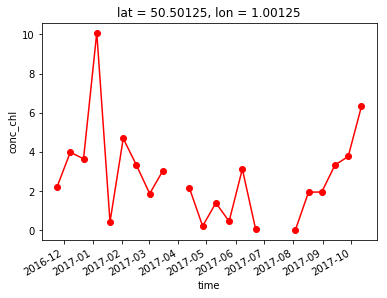

In [22]:
ds_resampled.conc_chl.sel(lon=1., lat=50.5, method='nearest').plot.line('r-o')

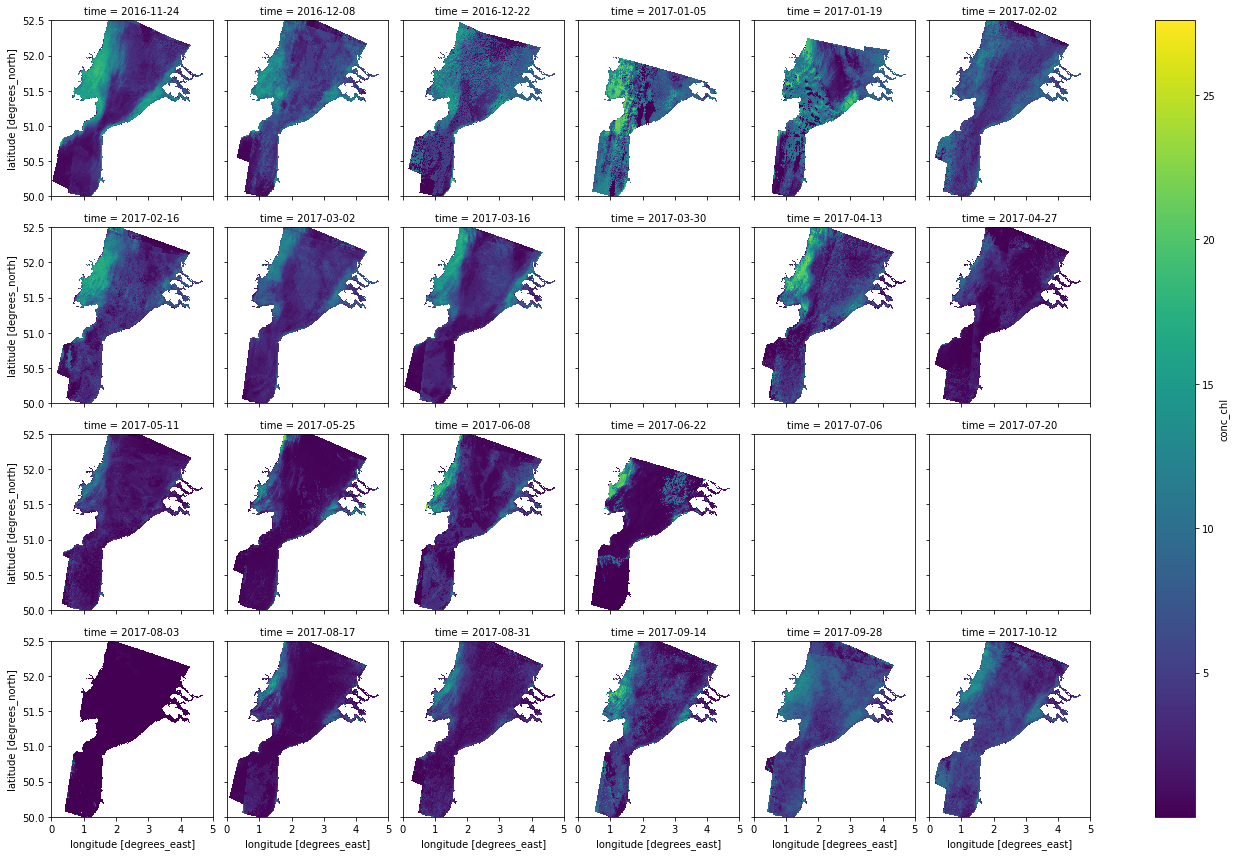

In [23]:
ds_resampled.conc_chl.plot.imshow(x='lon',y='lat',col='time',col_wrap=6)

In [24]:
res = ds.conc_chl.mean(dim='time')

In [25]:
ds_zscore = (ds-ds.mean(dim='time'))/ds.std(dim='time')

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 19036 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 16352 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
Future exception was never retrieved
future: <Future finished exception=PermissionError(13, 'Zugriff verweigert', None, 5, None)>
Traceback (most recent call last):
  File "C:\Users\Norman\Miniconda3\envs\xcube\lib\site-packages\distributed\process.py", line 35, in _call_and_set_future
    res = func(*args, **kwargs)
  File "C:\Users\Norman\Miniconda3\envs\xcube\lib\multiprocessing\process.py", line 124, in terminate
    self._popen.terminate()
  File "C:\Users\Norman\Miniconda3\envs\xcube\lib\multiprocessing\popen_spawn

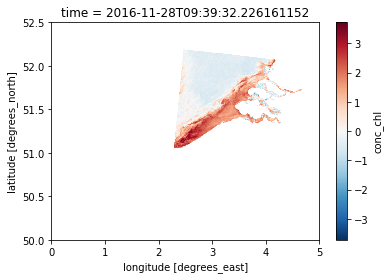

In [26]:
ds_zscore.conc_chl.isel(time=2).plot.imshow()

In [27]:
def above_Nsigma(x,Nsigma):
    return xr.ufuncs.fabs(x)>Nsigma

In [28]:
x_sigma =ds_zscore.apply(above_Nsigma,Nsigma = 1)

# Number of obs > 1 sigma

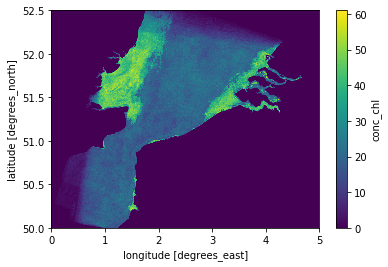

In [29]:
x_sigma.conc_chl.sum(dim="time",skipna = True).plot()

# Map projection

In [ ]:
plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds.conc_chl.isel(time=37).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=False)
ax.coastlines()
ax.set_ylim([49,53])
ax.set_xlim([-1,5])

# Match-up

In [ ]:
d = {'lat': np.random.uniform(low=51.5, high=52.5, size = 10), 'lon': np.random.uniform(low=2., high=3., size = 10), 'time': ['2017-01-01 10:12','2017-02-16 09:23','2017-06-18 12:34','2017-08-19 11:11','2017-11-28 08:34','2017-01-01 10:12','2017-02-16 09:23','2017-06-18 12:34','2017-08-19 11:11','2017-11-28 08:34'], 'CHL': np.random.uniform(low=0., high=32., size = 10) }

In [ ]:
insitu = pd.DataFrame(d)

In [ ]:
insitu.time = pd.to_datetime(insitu.time)

In [ ]:
insitu['CHL_SAT'] = ds_resampled.conc_chl.sel_points(lat = insitu.lat.values, lon = insitu.lon.values, time = insitu.time.values,method = "nearest")

In [ ]:
plt.plot(insitu.CHL,insitu.CHL_SAT,'k+')

In [ ]:
ds.conc_chl.where( (ds.conc_tsm < 15.) & (ds.conc_chl > 2.)).isel(time=4).plot.imshow()

In [ ]:
def DAT_corr(ds, var1 = None, var2 = None, dim ='time'):
   
    if not isinstance(ds,xr.Dataset):
        print('Input object ',ds,' is no xarray Dataset!')
        var1 = None

    if var1 is not None:  
        if var2 is None: 
            var2 = var1  
        ds_tmean = ds.mean(skipna=True, dim = dim)
        ds_tstd =  ds.std(skipna=True, dim = dim)
        covar_1 = (ds[var1] - ds_tmean[var1])*(ds[var2] - ds_tmean[var2])
        res = covar_1.mean(dim= 'time', skipna=True)/(ds_tstd[var1]*ds_tstd[var2])
    else: 
        res = None
        
    return res.persist()

In [ ]:
ds_corr = DAT_corr(ds,'conc_tsm', 'conc_chl')

In [ ]:
ds_corr

In [ ]:
ds_corr.plot.contourf(levels = np.linspace(.9,1,10))

In [ ]:
np.linspace(-1,1,41)

In [ ]:
ds.c2rcc_flags.isel(time=13).plot.imshow()